Activate the project

In [1]:
using Pkg
Pkg.activate(".")

  Activating environment at `/media/labfiles/nsom/repos/kp-lflm-group/src/KPpack/Project.toml`


# Load the package KPpack

In [2]:
using KPpack

┌ Info: Precompiling KPpack [9dccd583-b7b0-4bee-9ecf-2b58b37924d3]
└ @ Base loading.jl:1342


## test the bulk calculation

In [118]:
material="GaAs"; Temp=0; soc=true;
tipo="KaneII";
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

mm=KPpack.Materials(material,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0);
KPpack.ParMat(mm,Temp)
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
pl=1; pm=0; pn=0; kmax= 0.32; Nt=100;
Ex, Kx =KPpack.DiagM(mm,kmax,Nt,pl,pm,pn,soc,tipo);
#L
pl=1; pm=1; pn=1; kmax= 0.2; Nt=100;
El, Kl =KPpack.DiagM(mm,kmax,Nt,pl,pm,pn,soc,tipo);

#++++++++++++++++++++++++
K=vcat(-1*Kl,Kx); E=vcat(El,Ex);
EDOS, aDOS = KPpack.DOS(-2,2.2,0.01,E,0.04);

# Plot band diagram

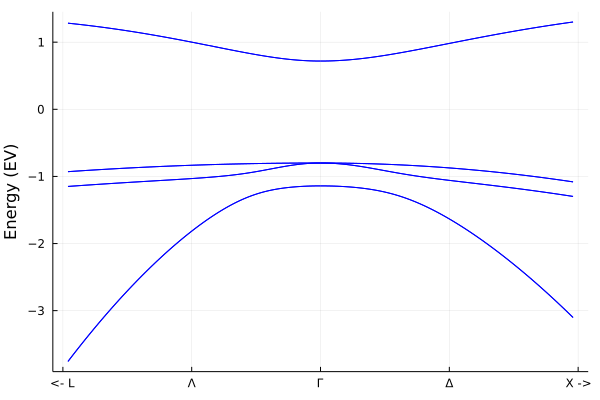

In [119]:
KPpack.PlotBands(Ex,El,Kx,Kl)

# Plot DOS

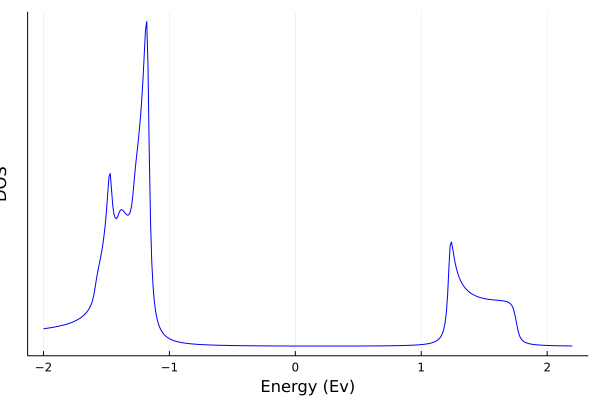

In [5]:
KPpack.PlotDOS(EDOS,aDOS)

# Make a structure

In [123]:
nlayer=7; Npts=110
layer=Array{KPpack.mat}(undef,nlayer)

layer[1]=KPpack.mat("GaAs",70);
layer[2]=KPpack.mat("AlGaAs_0.25",30);
layer[3]=KPpack.mat("GaAs",9);
layer[4]=KPpack.mat("AlGaAs_0.25",5);
layer[5]=KPpack.mat("GaAs",12);
layer[6]=KPpack.mat("AlGaAs_0.25",30);
layer[7]=KPpack.mat("GaAs",70);
X,boundary =KPpack.mesh(Npts,layer,nlayer);
mlayer=Array{KPpack.Materials}(undef, length(X));

boundPoints=KPpack.supParams(layer,X,boundary,mlayer,Temp);

# Plot structure

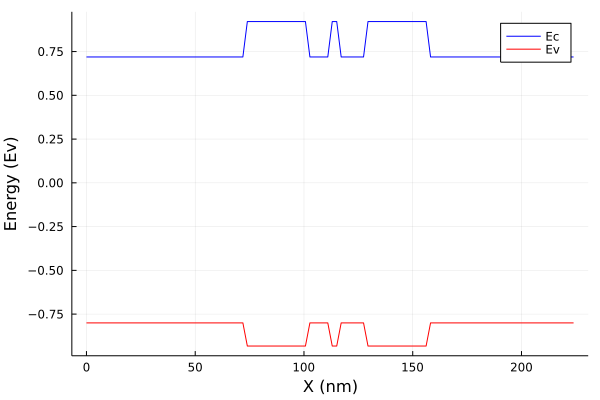

In [124]:
kind="both"
KPpack.plotProf(mlayer,X,kind)

# QW Band Structure Calculation

In [125]:
kmax= 0.1; Nt=60;
n=15; c=0.03;cp=30.0
sV=-0.8; sC=0.6

dx=X[2]-X[1]
pl=1; pm=1;
@time Ecq11,Evq11,Kqw11 =KPpack.DiagQWM(mlayer,kmax,Nt,dx,pl,pm,Npts,boundPoints,n,c,cp,sV,sC );

pl=1; pm=0;
@time Ecq10,Evq10,Kqw10 =KPpack.DiagQWM(mlayer,kmax,Nt,dx,pl,pm,Npts,boundPoints,n,c,cp,sV,sC );

 26.673669 seconds (93.79 M allocations: 54.382 GiB, 13.91% gc time)
 25.237492 seconds (93.78 M allocations: 54.261 GiB, 15.82% gc time)


## Valence Band 

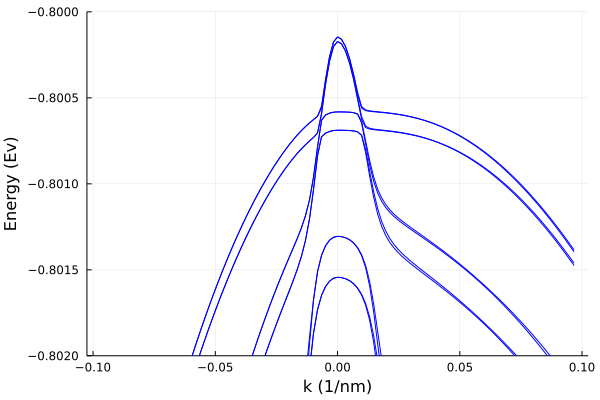

In [126]:
option="complete_V"; yinf,ysup= -0.802, -0.8
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,yinf,ysup)

# conduction Band

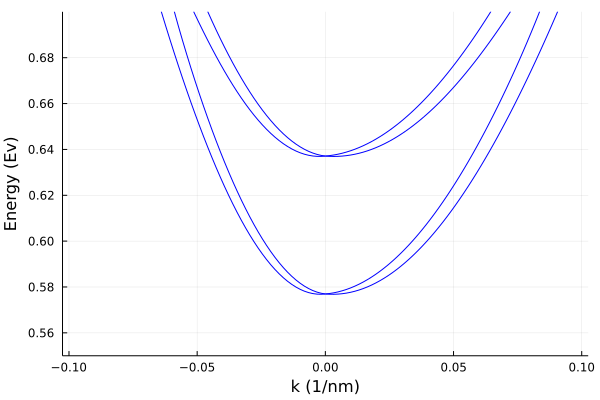

In [130]:
option="complete_C"; yinf,ysup= 0.55, 0.7
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,yinf,ysup)